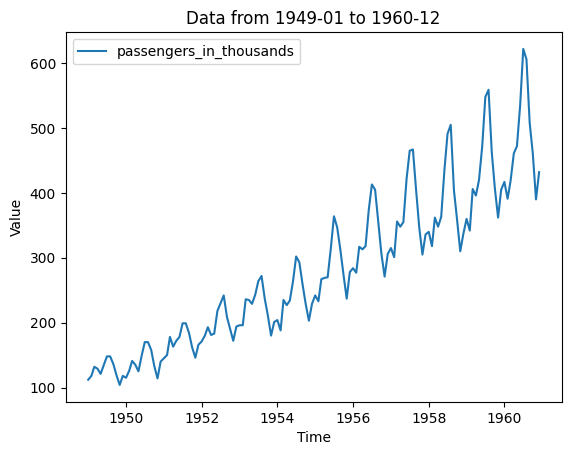

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data/airline/airline.csv')

def plot_csv_by_time(csv_path, start_time, end_time):
    # Load CSV file into a pandas dataframe
    df = pd.read_csv(csv_path,parse_dates=['Month'],  index_col=['Month'])
    
    # Select rows within the specified time range
    df = df.loc[start_time:end_time]
    
    # Generate a line plot for each column in the dataframe
    for col in df.columns:
        plt.plot(df.index, df[col], label=col)
    
    # Set plot title and axis labels
    plt.title(f"Data from {start_time} to {end_time}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    
    # Display legend and show plot
    plt.legend()
    plt.show()


plot_csv_by_time('data/airline/airline.csv', '1949-01', '1960-12')

# Tutorial


In [26]:
import sklearn
from tsai.basics import *

dsid = 'ILI'
df_raw = get_long_term_forecasting_data(dsid)
df_raw

KeyboardInterrupt: 

In [ ]:
datetime_col = "date"
freq = '7D'
columns = df_raw.columns[1:]
method = 'ffill'
value = 0

# pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage
    ('drop_duplicates', TSDropDuplicates(datetime_col=datetime_col)), # drop duplicate rows (if any)
    ('add_mts', TSAddMissingTimestamps(datetime_col=datetime_col, freq=freq)), # ass missing timestamps (if any)
    ('fill_missing', TSFillMissing(columns=columns, method=method, value=value)), # fill missing data (1st ffill. 2nd value=0)
    ], 
    verbose=True)
mkdir('data', exist_ok=True, parents=True)
save_object(preproc_pipe, 'data/preproc_pipe.pkl')
preproc_pipe = load_object('data/preproc_pipe.pkl')

df = preproc_pipe.fit_transform(df_raw)
df

data directory already exists.
Pipeline saved as data\preproc_pipe.pkl
Initial memory usage: 60.50 KB  
Final memory usage  : 30.31 KB   (-49.9%)
[Pipeline] .......... (step 1 of 4) Processing shrinker, total=   0.0s
[Pipeline] ... (step 2 of 4) Processing drop_duplicates, total=   0.0s
[Pipeline] ........... (step 3 of 4) Processing add_mts, total=   0.0s
[Pipeline] ...... (step 4 of 4) Processing fill_missing, total=   0.0s


,date,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,ILITOTAL,NUM. OF PROVIDERS,OT
0,2002-01-01,1.222620,1.166680,582,805,2060,754,176569
1,2002-01-08,1.333440,1.216500,683,872,2267,785,186355
2,2002-01-15,1.319290,1.130570,642,878,2176,831,192469
3,2002-01-22,1.494840,1.252460,728,1045,2599,863,207512
4,2002-01-29,1.471950,1.302370,823,1189,2907,909,223208
...,...,...,...,...,...,...,...,...
961,2020-06-02,0.839059,0.846722,2756,3528,12913,3258,1525058
962,2020-06-09,0.895958,0.908885,3203,3778,13979,3254,1538038
963,2020-06-16,0.910926,0.941625,3478,3796,14389,3177,1528103
964,2020-06-23,0.946945,0.972185,3734,3818,14999,3066,1542813


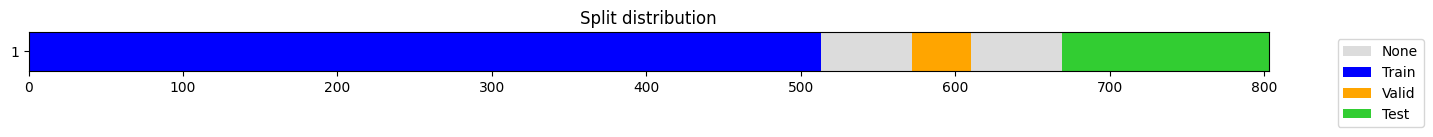

((#513) [0,1,2,3,4,5,6,7,8,9...],
 (#38) [572,573,574,575,576,577,578,579,580,581...],
 (#134) [669,670,671,672,673,674,675,676,677,678...])

In [ ]:
fcst_history = 104 # # steps in the past
fcst_horizon = 60  # # steps in the future
valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set

splits = get_long_term_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, dsid=dsid)
splits

In [ ]:
columns = df.columns[1:]
train_split = splits[0]

# pipeline
exp_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=columns)), # standardize data using train_split
    ], 
    verbose=True)
save_object(exp_pipe, 'data/exp_pipe.pkl')
exp_pipe = load_object('data/exp_pipe.pkl')

df_scaled = exp_pipe.fit_transform(df, scaler__idxs=train_split)
df_scaled

data directory already exists.
Pipeline saved as data\exp_pipe.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,date,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 5-24,ILITOTAL,NUM. OF PROVIDERS,OT
0,2002-01-01,-0.388910,-0.435545,-0.868236,-0.578640,-0.709860,-0.924247,-1.159122
1,2002-01-08,-0.299851,-0.392230,-0.818759,-0.563340,-0.685642,-0.859891,-1.113758
2,2002-01-15,-0.311222,-0.466939,-0.838844,-0.561970,-0.696289,-0.764394,-1.085416
3,2002-01-22,-0.170144,-0.360966,-0.796715,-0.523832,-0.646799,-0.697961,-1.015684
4,2002-01-29,-0.188539,-0.317573,-0.750177,-0.490947,-0.610764,-0.602464,-0.942924
...,...,...,...,...,...,...,...,...
961,2020-06-02,-0.697154,-0.713722,0.196745,0.043204,0.559907,4.274116,5.091879
962,2020-06-09,-0.651428,-0.659677,0.415718,0.100296,0.684625,4.265812,5.152048
963,2020-06-16,-0.639399,-0.631212,0.550432,0.104406,0.732594,4.105958,5.105994
964,2020-06-23,-0.610453,-0.604642,0.675839,0.109430,0.803962,3.875520,5.174183


In [ ]:
x_vars = df.columns[1:]
y_vars = df.columns[1:]

In [ ]:

X, y = prepare_forecasting_data(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
X.shape, y.shape

((803, 7, 104), (803, 7, 60))

In [ ]:

arch_config = dict(
    n_layers=3,  # number of encoder layers
    n_heads=4,  # number of heads
    d_model=16,  # dimension of model
    d_ff=128,  # dimension of fully connected network
    attn_dropout=0.0, # dropout applied to the attention weights
    dropout=0.3,  # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len=24,  # length of the patch applied to the time series to create patches
    stride=2,  # stride used when creating patches
    padding_patch=True,  # padding_patch
)

learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=ShowGraph())
# learn.dls.valid.drop_last = True
learn.summary()


not enough values to plot a chart


PatchTST (Input shape: 16 x 7 x 104)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 7 x 60         
RevIN                                     14         True      
____________________________________________________________________________
                     16 x 7 x 106        
ReplicationPad1d                                               
____________________________________________________________________________
                     16 x 24 x 42        
Unfold                                                         
____________________________________________________________________________
                     16 x 7 x 42 x 16    
Linear                                    400        True      
Dropout                                                        
Linear                                    272        True      
Linear                                    272        True      
Linear                                    272       

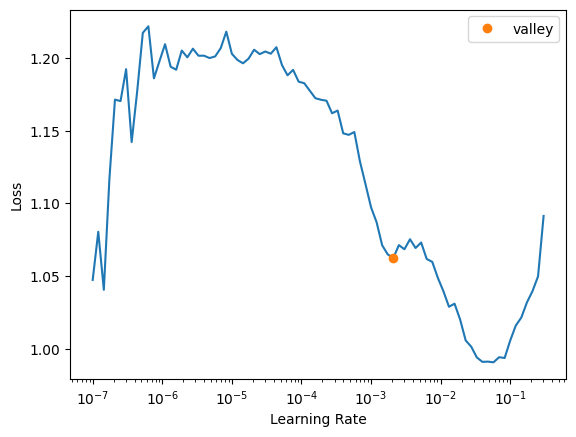

In [ ]:
lr_max = learn.lr_find().valley

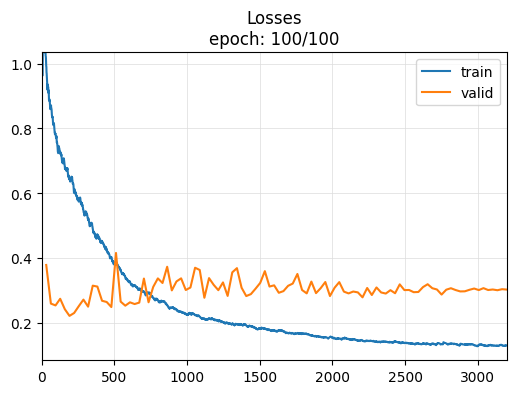

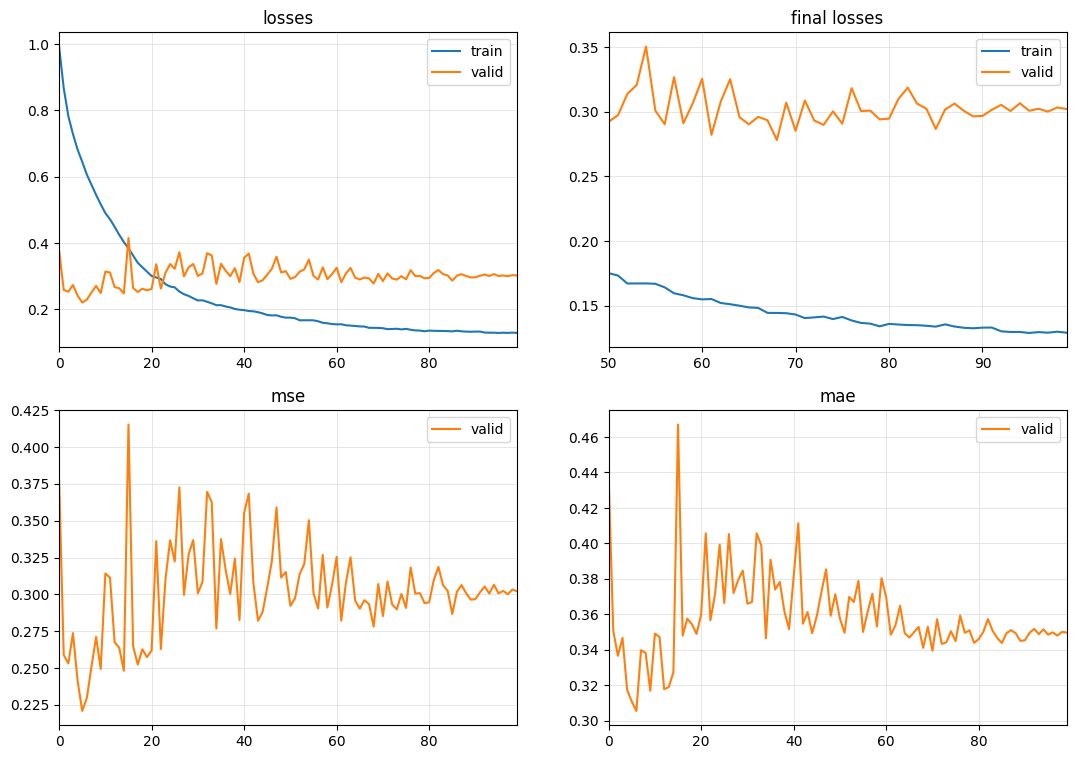

In [ ]:
learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, exp_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=[ShowGraph()])

n_epochs = 100
lr_max = 0.0025
learn.fit_one_cycle(n_epochs, lr_max=lr_max)
learn.export('patchTST.pt')

In [ ]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

learn = load_learner('models/patchTST.pt')
y_test_preds, *_ = learn.get_X_preds(X[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test = y[splits[2]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test.flatten(), y_test_preds.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test.flatten(), y_test_preds.flatten())
results_df

y_test_preds.shape: (134, 7, 60)


,mse,mae
test,1.572189,0.818228


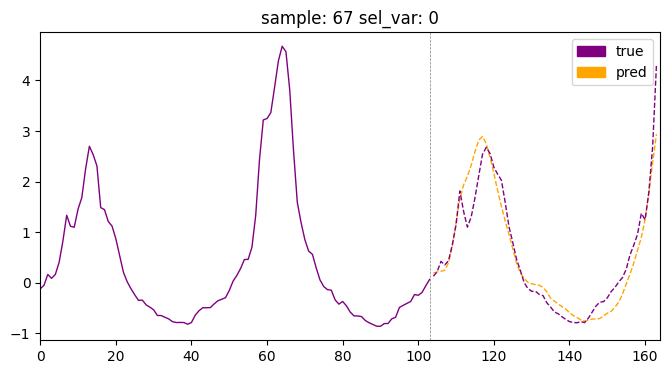

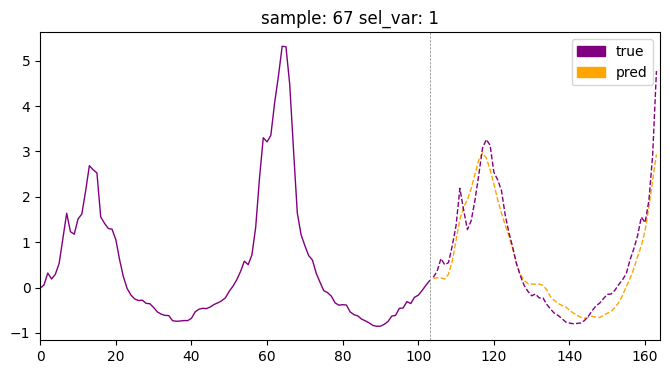

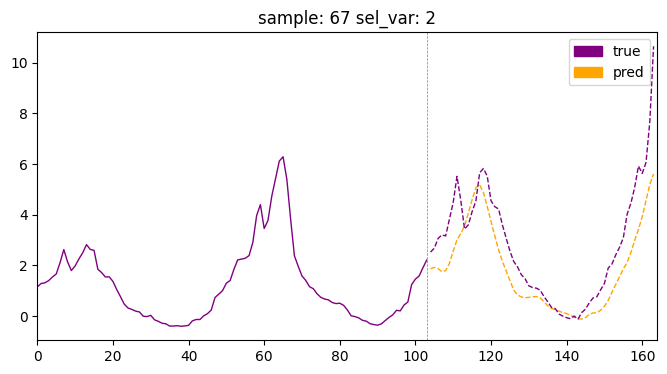

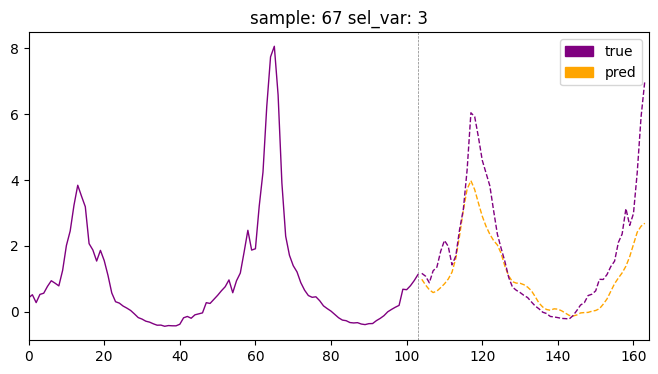

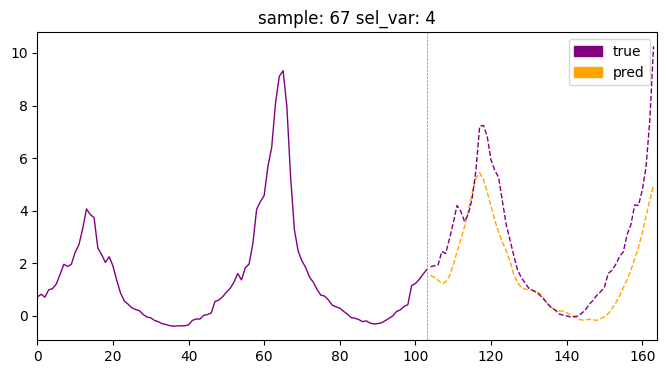

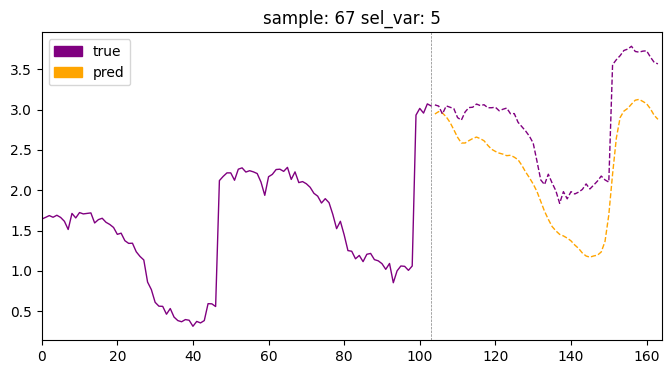

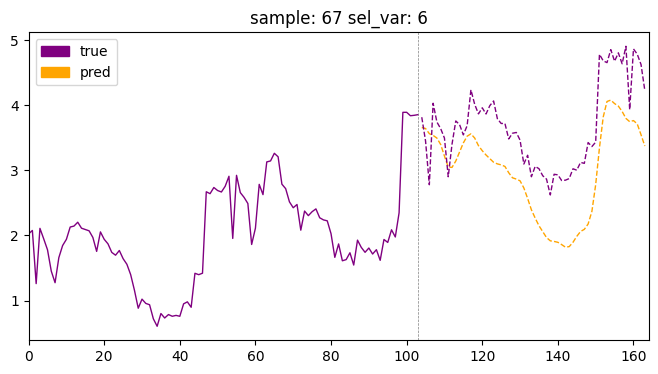

In [ ]:
X_test = X[splits[2]]
y_test = y[splits[2]]
plot_forecast(X_test, y_test, y_test_preds, sel_vars=True)
     

# Apply for custom data


In [3]:
from sklearn.base import TransformerMixin, BaseEstimator

class DateTimeConverter(TransformerMixin, BaseEstimator):
    def __init__(self, 
                 datetime_col):
        self.datetime_col = datetime_col
    def fit(self, X, y=None, **fit_params):
        X[self.datetime_col] = pd.to_datetime(X[self.datetime_col])
        return self
    def transform(self, X, y=None, **fit_params):
        X[self.datetime_col] = pd.to_datetime(X[self.datetime_col])
        return X

In [1]:
import sklearn
import pandas as pd
from pathlib import Path
from tsai.basics import *

dataPath = Path('data/airline/airline.csv', index_col='Month')
folderPath = dataPath.parent
df_raw = pd.read_csv(dataPath)
df_raw

,Month,passengers_in_thousands
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [3]:
datetime_col = "Month"
freq = 'MS'
columns = df_raw.columns[1:]
method = 'ffill'
value = 0

# pipeline
preproc_pipe = sklearn.pipeline.Pipeline([
    ('datetime_converter', DateTimeConverter(datetime_col=datetime_col)), # convert datetime column to datetime
    ('shrinker', TSShrinkDataFrame()), # shrink dataframe memory usage
    ('drop_duplicates', TSDropDuplicates(datetime_col=datetime_col)), # drop duplicate rows (if any)
    ('add_mts', TSAddMissingTimestamps(datetime_col=datetime_col, freq=freq)), # ass missing timestamps (if any)
    ('fill_missing', TSFillMissing(columns=columns, method=method, value=value)), # fill missing data (1st ffill. 2nd value=0)
    ], 
    verbose=True)

save_object(preproc_pipe, folderPath /'preproc_pipe.pkl')

data\airline directory already exists.
Pipeline saved as data\airline\preproc_pipe.pkl


In [4]:
preprocessPipePath = Path('data/airline/preproc_pipe.pkl')

preproc_pipe = load_object(preprocessPipePath)
df = preproc_pipe.fit_transform(df_raw)
df

[Pipeline]  (step 1 of 5) Processing datetime_converter, total=   0.0s
Initial memory usage: 2.38 KB   
Final memory usage  : 1.53 KB    (-35.5%)
[Pipeline] .......... (step 2 of 5) Processing shrinker, total=   0.0s
[Pipeline] ... (step 3 of 5) Processing drop_duplicates, total=   0.0s
[Pipeline] ........... (step 4 of 5) Processing add_mts, total=   0.0s
[Pipeline] ...... (step 5 of 5) Processing fill_missing, total=   0.0s


,Month,passengers_in_thousands
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


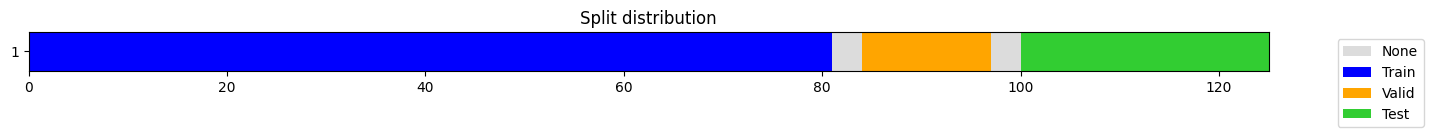

((#81) [0,1,2,3,4,5,6,7,8,9...],
 (#13) [84,85,86,87,88,89,90,91,92,93...],
 (#25) [100,101,102,103,104,105,106,107,108,109...])

In [5]:
fcst_history = 16 # # steps in the past
fcst_horizon = 4 # # steps in the future
valid_size   = 0.1  # int or float indicating the size of the training set
test_size    = 0.2  # int or float indicating the size of the test set

splits = get_long_term_forecasting_splits(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon)
splits

In [6]:
columns = df.columns[1:]
train_split = splits[0]

scalePipePath = Path('data/airline/scale_pipe.pkl')
# pipeline
scale_pipe = sklearn.pipeline.Pipeline([
    ('scaler', TSStandardScaler(columns=columns)), # standardize data using train_split
    ], 
    verbose=True)


save_object(scale_pipe, scalePipePath)
scale_pipe = load_object(scalePipePath)

df_scaled = scale_pipe.fit_transform(df, scaler__idxs=train_split)
df_scaled

data\airline directory already exists.
Pipeline saved as data\airline\scale_pipe.pkl
[Pipeline] ............ (step 1 of 1) Processing scaler, total=   0.0s


,Month,passengers_in_thousands
0,1949-01-01,-1.422473
1,1949-02-01,-1.319536
2,1949-03-01,-1.079351
3,1949-04-01,-1.130819
4,1949-05-01,-1.268068
...,...,...
139,1960-08-01,7.052636
140,1960-09-01,5.371339
141,1960-10-01,4.565003
142,1960-11-01,3.346920


In [7]:
x_vars = df.columns[1:]
y_vars = df.columns[1:]

In [8]:
X, y = prepare_forecasting_data(df, fcst_history=fcst_history, fcst_horizon=fcst_horizon, x_vars=x_vars, y_vars=y_vars)
X.shape, y.shape

((125, 1, 16), (125, 1, 4))

In [19]:
arch_config = dict(
    n_layers=3,  # number of encoder layers
    n_heads=4,  # number of heads
    d_model=16,  # dimension of model
    d_ff=128,  # dimension of fully connected network
    attn_dropout=0.0, # dropout applied to the attention weights
    dropout=0.3,  # dropout applied to all linear layers in the encoder except q,k&v projections
    patch_len=12,  # length of the patch applied to the time series to create patches
    stride=2,  # stride used when creating patches
    padding_patch=True,  # padding_patch
)

# learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, scale_pipe],
#                      arch="PatchTST", arch_config = arch_config, metrics=[mse, mae], cbs=ShowGraph())
learn = TSForecaster(X, y, splits=splits, batch_size=16, path="models", pipelines=[preproc_pipe, scale_pipe],
                     arch="LSTMPlus", metrics=[mse, mae], cbs=ShowGraph())
learn.dls.valid.drop_last = True
learn.summary()

not enough values to plot a chart


LSTMPlus (Input shape: 16 x 1 x 16)
Layer (type)         Output Shape         Param #    Trainable 
                     16 x 1 x 16         
Identity                                                       
Identity                                                       
____________________________________________________________________________
                     16 x 16 x 100       
LSTM                                                           
____________________________________________________________________________
                     16 x 16 x 100       
LSTMOutput                                                     
____________________________________________________________________________
                     16 x 100 x 16       
Transpose                                                      
____________________________________________________________________________
                     16 x 1600           
Reshape                                                       

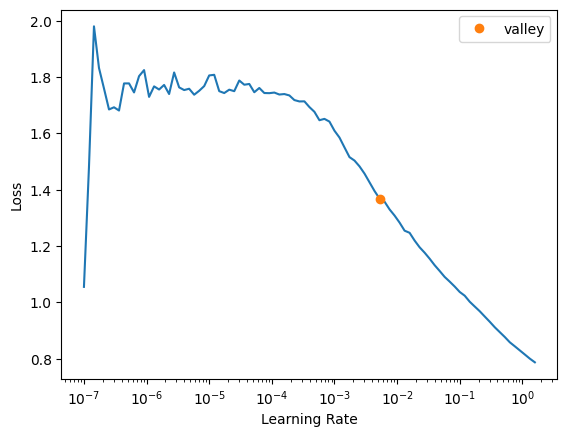

In [20]:
lr_max = learn.lr_find().valley

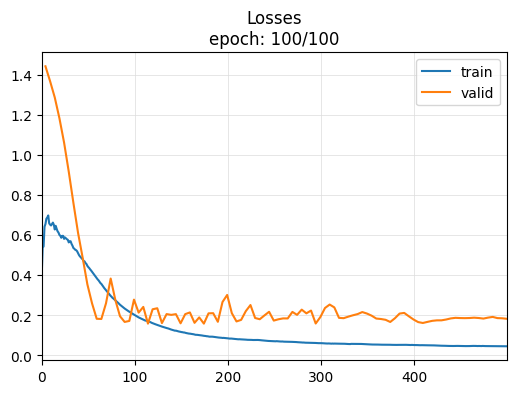

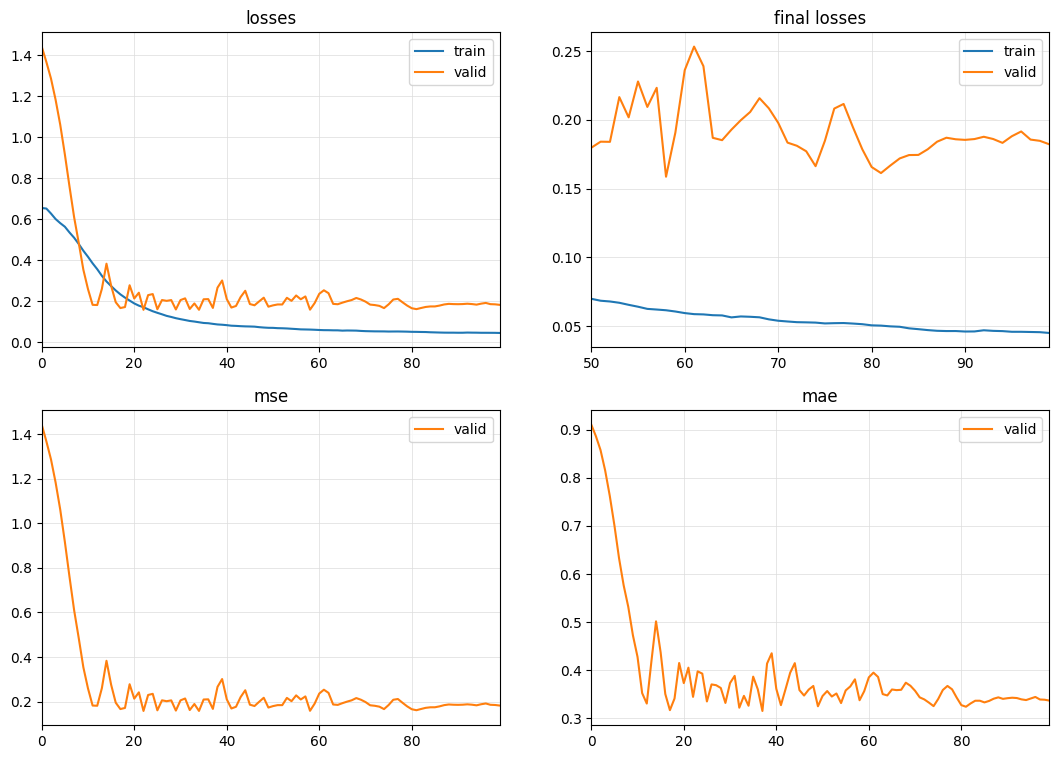

In [21]:
modelPath = Path('data/airline')
learn = TSForecaster(X, y, splits=splits, batch_size=16, path=modelPath, pipelines=[preproc_pipe, scale_pipe],
                     arch="PatchTST", arch_config=arch_config, metrics=[mse, mae], cbs=[ShowGraph()])

n_epochs = 100
learn.fit_one_cycle(n_epochs, lr_max=lr_max)
learn.export('patchTST.pt')

In [22]:
from tsai.inference import load_learner
from sklearn.metrics import mean_squared_error, mean_absolute_error

modelPath = Path('data/airline/patchTST.pt')
learn = load_learner(modelPath)
y_test_preds, *_ = learn.get_X_preds(X[splits[2]])
y_test_preds = to_np(y_test_preds)
print(f"y_test_preds.shape: {y_test_preds.shape}")

y_test = y[splits[2]]
results_df = pd.DataFrame(columns=["mse", "mae"])
results_df.loc["test", "mse"] = mean_squared_error(y_test.flatten(), y_test_preds.flatten())
results_df.loc["test", "mae"] = mean_absolute_error(y_test.flatten(), y_test_preds.flatten())
results_df

y_test_preds.shape: (25, 1, 4)


,mse,mae
test,0.095173,0.244977


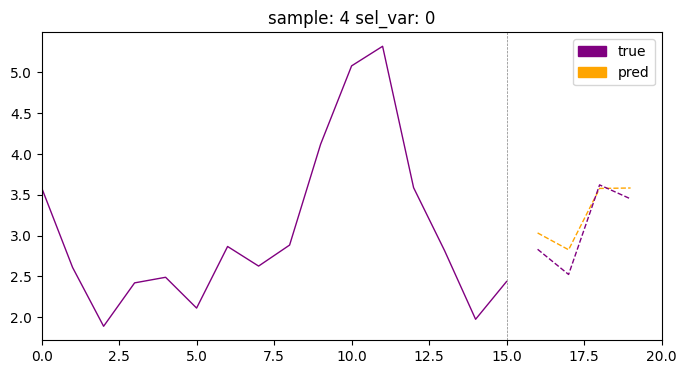

In [54]:
X_test = X[splits[2]]
y_test = y[splits[2]]
plot_forecast(X_test, y_test, y_test_preds, sel_vars=True)

In [51]:
learn.pipelines

[Pipeline(steps=[('datetime_converter', DateTimeConverter(datetime_col='Month')),
                 ('shrinker', TSShrinkDataFrame(columns=[], skip=[])),
                 ('drop_duplicates',
                  TSDropDuplicates(datetime_col=['Month'], unique_id_cols=[])),
                 ('add_mts',
                  TSAddMissingTimestamps(datetime_col='Month', freq='MS')),
                 ('fill_missing',
                  TSFillMissing(columns=[Index(['passengers_in_thousands'], dtype='object')]))],
          verbose=True),
 Pipeline(steps=[('scaler',
                  TSStandardScaler(columns=[Index(['passengers_in_thousands'], dtype='object')],
                                   eps=array(1.e-06, dtype=float32),
                                   mean=[passengers_in_thousands    194.91358
 dtype: float64],
                                   std=[passengers_in_thousands    58.288334
 dtype: float64]))],
          verbose=True)]